In [41]:
# Initial imports
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)
from sklearn.model_selection import train_test_split
import pickle

## Loading the spam detection dataset
- The dataset is available <a href="https://www.kaggle.com/ozlerhakan/spam-or-not-spam-dataset">here</a>.
- This is the simplified version of Apache spam assassin's public database originally sourced from <a href="https://spamassassin.apache.org/old/publiccorpus/">here</a>.
- This has 2500 normal and 500 spam emails.
- We will use a pretrained uncased <a href="https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4">BERT</a> model to get word vectors.

In [27]:
spam = pd.read_csv("spam.csv")
spam.head(2)

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMBER NUMBER from chris garrigues cwg dated NUMBER NUMBERfaNUMBERd deepeddy com message id NUMBER NUMBER tmda deepeddy vircio com i can t reproduce this error for me it is very repeatable like every time without fail this is the debug log of the pick happening NUMBER NUMBER NUMBER pick_it exec pick inbox list lbrace lbrace subject ftp rbrace rbrace NUMBER NUMBER sequence mercury NUMBER NUMBER NUMBER exec pick inbox list lbrace lbrace subject ftp rbrace rbrace NUMBER NUMBER sequence mercury NUMBER NUMBER NUMBER ftoc_pickmsgs NUMBER hit NUMBER NUMBER NUMBER marking NUMBER hits NUMBER NUMBER NUMBER tkerror syntax error in expression int note if i run the pick command by hand delta pick inbox list lbrace lbrace subject ftp rbrace rbrace NUMBER NUMBER sequence mercury NUMBER hit that s where the NUMBER hit comes from obviously the version of nmh i m using is delta pick version pick nmh NUMBER NUMBER NUMBER compiled on URL at sun mar NUMBER NUMBER NUMBER NUMBER ict NUMBER and the relevant part of my mh_profile delta mhparam pick seq sel list since the pick command works the sequence actually both of them the one that s explicit on the command line from the search popup and the one that comes from mh_profile do get created kre ps this is still using the version of the code form a day ago i haven t been able to reach the cvs repository today local routing issue i think _______________________________________________ exmh workers mailing list exmh workers URL URL,0
1,martin a posted tassos papadopoulos the greek sculptor behind the plan judged that the limestone of mount kerdylio NUMBER miles east of salonika and not far from the mount athos monastic community was ideal for the patriotic sculpture as well as alexander s granite features NUMBER ft high and NUMBER ft wide a museum a restored amphitheatre and car park for admiring crowds are planned so is this mountain limestone or granite if it s limestone it ll weather pretty fast yahoo groups sponsor NUMBER dvds free s p join now URL to unsubscribe from this group send an email to forteana unsubscribe URL your use of yahoo groups is subject to URL,0


The numbers have been replaced with "NUMBER" and similarly with the web urls replaced with "URL"

In [14]:
ls = spam['email'].apply(lambda x: len(str(x).split()))
print("Max words", ls.max())
print("Min words", ls.min())

Max words 13303
Min words 0


In [16]:
spam[spam["email"].str.len() <= 30]

,email,label
806,URL,0
1953,url URL date not supplied URL,0
1955,url URL date not supplied URL,0
1956,url URL date not supplied URL,0
1957,url URL date not supplied URL,0
1958,url URL date not supplied URL,0
1959,url URL date not supplied URL,0
1961,url URL date not supplied URL,0
2009,url URL date not supplied URL,0
2105,url URL date not supplied URL,0


In [7]:
spam = spam[spam["email"].str.len() > 30]

We only keep rows with sentence length greater than 30 since they have no valuable data

In [ ]:
spam.shape

(2986, 2)

In [38]:
# Basic preprocessing

# Replace the numbers or web links with NUMBER and URL 
def init_preprocess(x):
    x = re.sub(r'don\'t', 'do not', x)
    x = re.sub(r'won\'t', 'will not', x)
    x = re.sub(r'can\'t', 'cannot', x)
    x = re.sub(r'shouldn\'t', 'should not', x)
    x = re.sub(r'couldn\'t', 'could not', x)
    x = re.sub(r'didn\'t', 'did not', x)
    x = re.sub(r'wouldn\'t', 'would not', x)
    x = re.sub(r'shan\'t', 'shall not', x)
    x = re.sub(r'could\'ve', 'could have', x)
    x = re.sub(r'would\'ve', 'would have', x)
    x = re.sub(r'should\'ve', 'should have', x)
    x = re.sub(r'(\s[0-9\-.]+)'," NUMBER", x)
    x = re.sub(r"http\S+", " URL", x)
    return x

# This is to add a column if a NUMBER or URL is present
# This can be changed to a count of NUMBER or URL
def is_present(df, val):
    def presence(x):
        if val in x: return 1
        else: return 0
    df[val+"_present"] = df["email"].apply(presence)
    return df

# Removing NUMBER and URL after recording their presence
def preprocess(x):
    x = str(x)
    x = re.sub("[^A-Za-z0-9]", "  ", x)
    x = re.sub("NUMBER|URL", " ", x)
    x = re.sub("  +", " ", x)
    return x.strip()

In [114]:
spam["email"] = spam["email"].apply(init_preprocess)
spam = is_present(spam, "NUMBER")
spam = is_present(spam, "URL")
spam["email"] = spam["email"].apply(preprocess)
spam.head(2)

,email,label,NUMBER_present,URL_present
0,date wed aug from chris garrigues cwg dated fa d deepeddy com message id tmda deepeddy vircio com i can t reproduce this error for me it is very repeatable like every time without fail this is the debug log of the pick happening pick it exec pick inbox list lbrace lbrace subject ftp rbrace rbrace sequence mercury exec pick inbox list lbrace lbrace subject ftp rbrace rbrace sequence mercury ftoc pickmsgs hit marking hits tkerror syntax error in expression int note if i run the pick command by hand delta pick inbox list lbrace lbrace subject ftp rbrace rbrace sequence mercury hit that s where the hit comes from obviously the version of nmh i m using is delta pick version pick nmh compiled on at sun mar ict and the relevant part of my mh profile delta mhparam pick seq sel list since the pick command works the sequence actually both of them the one that s explicit on the command line from the search popup and the one that comes from mh profile do get created kre ps this is still using the version of the code form a day ago i haven t been able to reach the cvs repository today local routing issue i think exmh workers mailing list exmh workers,0,1,1
1,martin a posted tassos papadopoulos the greek sculptor behind the plan judged that the limestone of mount kerdylio miles east of salonika and not far from the mount athos monastic community was ideal for the patriotic sculpture as well as alexander s granite features ft high and ft wide a museum a restored amphitheatre and car park for admiring crowds are planned so is this mountain limestone or granite if it s limestone it ll weather pretty fast yahoo groups sponsor dvds free s p join now to unsubscribe from this group send an email to forteana unsubscribe your use of yahoo groups is subject to,0,1,1


In [115]:
# Saving
#spam.to_csv("p_spam.csv", index=False)

In [3]:
# Loading
#spam = pd.read_csv("p_spam.csv")

In [185]:
# We split the dataset into train and test
enc = onh(sparse=False)
X = spam.drop(columns=["label"])
Y = enc.fit_transform(spam[["label"]])

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=734)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(2388, 3) (2388, 2)
(598, 3) (598, 2)


## Creating BERT model

- This is bert_en_uncased_L-12_H-768_A-12
- We are using an uncased BERT with 12 hidden layers, 12 Attention layers and 768 hidden size or output dimension.
- This model has been pretrained for English on Wikipedia and BooksCorpus.
- This is called "uncased" because the text was lower-cased before tokenization.
- We are also going to use the tokenization provided by google-research
- Since BERT has a position embedding for token embeddings for each input and this comes from a lookup table, the size is fixed for the lookup table. This imposes a max sequence length of 512.

In [11]:

max_seq_length = 512

# BERT takes 3 inputs
# This is in form of a dictionary
# input_word_ids for sequence of words represented as integers.
# input_mask for padding
# segment_ids if only one sentence per classification, the total seg vector is 0. 
# If two sentences are given with [sep] token inbetween them, the first seq segment vectors are zeros and 
# second seq segment vector are 1's

encoder_inputs = dict(
    input_word_ids=tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32),
    input_mask=tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32),
    input_type_ids=tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32),
)
# BERT layer 
# Pooled output for each input sentence as a whole
# Sequence output to represent each token in context 
# We are only using the pooled output for now
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", trainable=False)
outputs = bert_encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]
seq_output = outputs["sequence_output"]
# Make the model
bert_model = Model(inputs=encoder_inputs, outputs=pooled_output)


In [16]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'default': (None, 7 109482241   input_2[0][0]                    
                                                                 input_3[0][0]                

## Tokenization

In [12]:
# getting Vocab file from BERT
vocab_file = bert_encoder.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_encoder.resolved_object.do_lower_case.numpy()
pickle.dump(vocab_file, open('bert_vocab.pkl', 'wb'))
pickle.dump(do_lower_case, open('bert_lowercase.pkl', 'wb'))

In [18]:
# Download the tokenization.py file from github
# https://raw.githubusercontent.com/google-research/bert/master/tokenization.py
from tokenization import FullTokenizer

In [19]:
tokenizer = FullTokenizer(vocab_file, do_lower_case)

In [21]:
#pickle.dump(tokenizer, open('tokenizer_save.pkl','wb'))

In [120]:
# Helper function for tokenization
# This adds [CLS] and [SEP] to each sentence after tokenization and [PAD] for padding
# The mask and segment vector for each input is also calculated
def tokenizer_func(x):
    max_seq_len = 512
    tokens_arr, mask, segment = [], [], np.zeros((len(x), max_seq_len))
    for i,sent in enumerate(tqdm(x['email'].values)):
        tokens = tokenizer.tokenize(sent)
        tokens = tokens[:(max_seq_len-2)]
        tokens = ['[CLS]',*tokens,'[SEP]']
        zeros = len(tokens)
        while len(tokens)<max_seq_len:
            tokens.append('[PAD]')
        tokens_arr.append(tokenizer.convert_tokens_to_ids(tokens))
        mask.append([1]*zeros+[0]*(max_seq_len - zeros))
    return np.array(tokens_arr), np.array(mask), segment

In [187]:
x_train_tokens, x_train_mask, x_train_segment = tokenizer_func(x_train)
x_test_tokens, x_test_mask, x_test_segment = tokenizer_func(x_test)  
print(x_train_tokens[:5])
print(x_train_mask[:5])
print(x_train_segment[:5])

100%|██████████| 598/598 [00:04<00:00, 131.81it/s]

[[  101  2006 10722 ...     0     0     0]
 [  101  4931  2144 ...     0     0     0]
 [  101  1045  2109 ...     0     0     0]
 [  101 23760 13767 ...     0     0     0]
 [  101 24471  2140 ...     0     0     0]]
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
# Check the input and output
bert_model.input

{'input_word_ids': <KerasTensor: shape=(None, 13300) dtype=int32 (created by layer 'input_16')>,
 'input_mask': <KerasTensor: shape=(None, 13300) dtype=int32 (created by layer 'input_17')>,
 'input_type_ids': <KerasTensor: shape=(None, 13300) dtype=int32 (created by layer 'input_18')>}

In [ ]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer_6')>

## Prediction

In [188]:
# Get predictions for the sequences

inp = dict(input_word_ids=x_train_tokens, input_mask=x_train_mask, input_type_ids=x_train_segment)
x_train_bert_output=bert_model.predict(inp)
inp_te = dict(input_word_ids=x_test_tokens, input_mask=x_test_mask, input_type_ids=x_test_segment)
x_test_bert_output=bert_model.predict(inp_te)

## Create a model to train with the BERT predictions to solve the original problem

- To solve the original problem, we create a Dense model with the BERT predictions as our input to the model.
- The model has 4 hidden layers followed by an output layer with the softmax activation function.
- To prevent an overfit, we use Dropout layers in between.
- Also since the dataset is imbalanced, we use class weights to get a robust model.

In [190]:
##import
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, LeakyReLU
from tensorflow.keras.models import Model
from sklearn.utils.class_weight import compute_class_weight
from numpy import hstack

In [196]:
# For unbalanced data
class_weights = list(compute_class_weight('balanced', np.unique(spam["label"]), spam["label"]))
class_weights = {0:class_weights[0], 1:class_weights[1]}
print(class_weights)

{0: 0.5998392928887103, 1: 3.004024144869215}


In [197]:
# Stacking the two extra columns from earlier
x_train_fin = np.hstack((x_train_bert_output, x_train["NUMBER_present"].values.reshape(-1,1), x_train["URL_present"].values.reshape(-1,1)))
x_test_fin = np.hstack((x_test_bert_output, x_test["NUMBER_present"].values.reshape(-1,1), x_test["URL_present"].values.reshape(-1,1)))

In [198]:
# Model 
ip = Input(shape=(770,))
x = Dense(1024)(ip)
x = LeakyReLU()(x)
x = Dropout(0.2)(x)
x = Dense(1024)(x)
x = LeakyReLU()(x)
x = Dropout(0.2)(x)
x = Dense(512)(x)
x = LeakyReLU()(x)
x = Dropout(0.2)(x)
x = Dense(64)(x)
x = LeakyReLU()(x)
x = Dropout(0.2)(x)
out = Dense(2, activation='softmax')(x)
model = Model(ip, out)
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 770)]             0         
_________________________________________________________________
dense_15 (Dense)             (None, 1024)              789504    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 1024)              0   

In [199]:
# Callbacks and compile
ckp_path = "/checkpoint"
ckp = tf.keras.callbacks.ModelCheckpoint(filepath=ckp_path,monitor="val_accuracy",verbose=0, save_best_only=True, save_freq="epoch")
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy', 'AUC'])

In [200]:
# Train for 20 epochs
hist = model.fit(x_train_fin, y_train, batch_size=128, epochs=20, class_weight=class_weights,\
                 validation_data=(x_test_fin, y_test), callbacks=[ckp])

Epoch 1/20
19/19 [==============================] - 1s 29ms/step - loss: 1.0830 - accuracy: 0.5297 - auc: 0.5232 - val_loss: 0.7986 - val_accuracy: 0.2007 - val_auc: 0.2221
INFO:tensorflow:Assets written to: /checkpoint/assets


INFO:tensorflow:Assets written to: /checkpoint/assets


Epoch 2/20
19/19 [==============================] - 0s 10ms/step - loss: 0.7069 - accuracy: 0.5787 - auc: 0.6070 - val_loss: 0.5280 - val_accuracy: 0.8127 - val_auc: 0.8912
INFO:tensorflow:Assets written to: /checkpoint/assets


INFO:tensorflow:Assets written to: /checkpoint/assets


Epoch 3/20
19/19 [==============================] - 0s 11ms/step - loss: 0.5670 - accuracy: 0.7462 - auc: 0.8075 - val_loss: 0.6628 - val_accuracy: 0.5786 - val_auc: 0.6386
Epoch 4/20
19/19 [==============================] - 0s 10ms/step - loss: 0.4244 - accuracy: 0.8216 - auc: 0.8919 - val_loss: 0.9023 - val_accuracy: 0.4666 - val_auc: 0.5234
Epoch 5/20
19/19 [==============================] - 0s 10ms/step - loss: 0.3621 - accuracy: 0.8371 - auc: 0.9167 - val_loss: 0.8468 - val_accuracy: 0.6773 - val_auc: 0.7400
Epoch 6/20
19/19 [==============================] - 0s 11ms/step - loss: 0.3975 - accuracy: 0.8400 - auc: 0.9116 - val_loss: 0.3707 - val_accuracy: 0.8344 - val_auc: 0.9158
INFO:tensorflow:Assets written to: /checkpoint/assets


INFO:tensorflow:Assets written to: /checkpoint/assets


Epoch 7/20
19/19 [==============================] - 0s 11ms/step - loss: 0.2748 - accuracy: 0.8865 - auc: 0.9539 - val_loss: 0.1906 - val_accuracy: 0.9130 - val_auc: 0.9802
INFO:tensorflow:Assets written to: /checkpoint/assets


INFO:tensorflow:Assets written to: /checkpoint/assets


Epoch 8/20
19/19 [==============================] - 0s 11ms/step - loss: 0.2725 - accuracy: 0.9008 - auc: 0.9588 - val_loss: 0.2197 - val_accuracy: 0.9114 - val_auc: 0.9701
Epoch 9/20
19/19 [==============================] - 0s 11ms/step - loss: 0.2563 - accuracy: 0.9049 - auc: 0.9623 - val_loss: 0.3175 - val_accuracy: 0.8863 - val_auc: 0.9427
Epoch 10/20
19/19 [==============================] - 0s 10ms/step - loss: 0.1762 - accuracy: 0.9397 - auc: 0.9838 - val_loss: 0.1272 - val_accuracy: 0.9415 - val_auc: 0.9899
INFO:tensorflow:Assets written to: /checkpoint/assets


INFO:tensorflow:Assets written to: /checkpoint/assets


Epoch 11/20
19/19 [==============================] - 0s 10ms/step - loss: 0.2901 - accuracy: 0.8836 - auc: 0.9495 - val_loss: 0.1309 - val_accuracy: 0.9565 - val_auc: 0.9906
INFO:tensorflow:Assets written to: /checkpoint/assets


INFO:tensorflow:Assets written to: /checkpoint/assets


Epoch 12/20
19/19 [==============================] - 0s 13ms/step - loss: 0.1807 - accuracy: 0.9363 - auc: 0.9816 - val_loss: 0.1210 - val_accuracy: 0.9615 - val_auc: 0.9913
INFO:tensorflow:Assets written to: /checkpoint/assets


INFO:tensorflow:Assets written to: /checkpoint/assets


Epoch 13/20
19/19 [==============================] - 0s 10ms/step - loss: 0.1862 - accuracy: 0.9288 - auc: 0.9777 - val_loss: 0.1203 - val_accuracy: 0.9515 - val_auc: 0.9920
Epoch 14/20
19/19 [==============================] - 0s 14ms/step - loss: 0.2316 - accuracy: 0.9116 - auc: 0.9670 - val_loss: 0.1401 - val_accuracy: 0.9532 - val_auc: 0.9914
Epoch 15/20
19/19 [==============================] - 0s 10ms/step - loss: 0.1804 - accuracy: 0.9338 - auc: 0.9801 - val_loss: 0.1179 - val_accuracy: 0.9532 - val_auc: 0.9915
Epoch 16/20
19/19 [==============================] - 0s 10ms/step - loss: 0.1662 - accuracy: 0.9301 - auc: 0.9818 - val_loss: 0.0984 - val_accuracy: 0.9682 - val_auc: 0.9942
INFO:tensorflow:Assets written to: /checkpoint/assets


INFO:tensorflow:Assets written to: /checkpoint/assets


Epoch 17/20
19/19 [==============================] - 0s 10ms/step - loss: 0.1187 - accuracy: 0.9510 - auc: 0.9913 - val_loss: 0.1207 - val_accuracy: 0.9548 - val_auc: 0.9909
Epoch 18/20
19/19 [==============================] - 0s 11ms/step - loss: 0.1515 - accuracy: 0.9359 - auc: 0.9838 - val_loss: 0.1025 - val_accuracy: 0.9615 - val_auc: 0.9938
Epoch 19/20
19/19 [==============================] - 0s 11ms/step - loss: 0.1342 - accuracy: 0.9535 - auc: 0.9907 - val_loss: 0.1703 - val_accuracy: 0.9281 - val_auc: 0.9830
Epoch 20/20
19/19 [==============================] - 0s 11ms/step - loss: 0.1117 - accuracy: 0.9590 - auc: 0.9916 - val_loss: 0.0845 - val_accuracy: 0.9716 - val_auc: 0.9961
INFO:tensorflow:Assets written to: /checkpoint/assets


INFO:tensorflow:Assets written to: /checkpoint/assets


In [201]:
# Load the best model with the highest validation accuracy
model.load_weights(ckp_path)
model.evaluate(x_test_fin, y_test)

19/19 [==============================] - 0s 5ms/step - loss: 0.0845 - accuracy: 0.9716 - auc: 0.9961


[0.08453422039747238, 0.9715719223022461, 0.9960683584213257]

In [ ]:
#model.save("bert_spam")

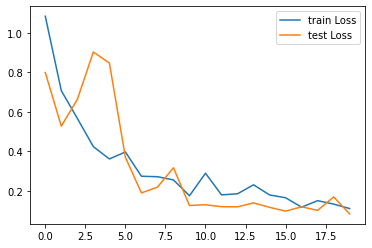

In [203]:
# Loss plot
plt.plot(range(20) ,hist.history['loss'], label='train Loss')
plt.plot(range(20) ,hist.history['val_loss'], label='test Loss')
plt.legend()
plt.show()

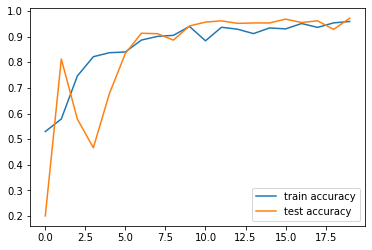

In [204]:
# Accuracy plot
plt.plot(range(20) ,hist.history['accuracy'], label='train accuracy')
plt.plot(range(20) ,hist.history['val_accuracy'], label='test accuracy')
plt.legend()
plt.show()

## Create pipeline for future input

In [ ]:
# Loading saved functions and models
bert_model = tf.keras.models.load_model('encoder_model')
vocab_file = pickle.load(open('bert_vocab.pkl', 'rb'))
do_lower_case = pickle.load(open('bert_lowercase.pkl', 'rb'))
model = tf.keras.models.load_model('bert_spam')
tokenizer = pickle.load(open('tokenizer_save.pkl','rb'))

In [34]:
# Making a pipeline to process and predict the a given sentence

def pipeline(x):
    x = init_preprocess(x)
    num_pres = np.array(1 if "NUMBER" in x else 0).reshape(1,-1)
    url_pres =  np.array(1 if "URL" in x else 0).reshape(1,-1)
    x = preprocess(x)
    max_seq_len = 512
    segment = np.zeros((1, max_seq_len))
    tokens = tokenizer.tokenize(x)
    tokens = tokens[:(max_seq_len-2)]
    tokens = ['[CLS]',*tokens,'[SEP]']
    zeros = len(tokens)
    while len(tokens)<max_seq_len:
        tokens.append('[PAD]')
    tokens = np.array(tokenizer.convert_tokens_to_ids(tokens)).reshape(1,-1)
    mask = np.array([1]*zeros+[0]*(max_seq_len - zeros)).reshape(1,-1)
    pred = bert_model.predict(dict(input_word_ids=tokens, input_mask=mask, input_type_ids=segment))
    fin_arr = np.hstack((pred, num_pres, url_pres))
    fpred = model.predict(fin_arr)
    if np.argmax(fpred) == 1: 
        print("This is a spam")
        print("Confidence: {}%".format(round(fpred[0][1]*100,2)))
    else: 
        print("This is legit")
        print("Confidence: {}%".format(round(fpred[0][0]*100,2)))

In [40]:
# General example
sent = "I am here to help, please send me your money, I will double it in 50 days."
pipeline(sent)

This is a spam
Confidence: 97.59%
